<a href="https://colab.research.google.com/github/tommymmcguire/DeerAI-540/blob/main/classical_approach_deer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Remove Colab default sample_data
!rm -r ./sample_data

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from concurrent.futures import ProcessPoolExecutor, as_completed
import re
from tqdm import tqdm

def resize_image(image, target_height=500):
    """Resize images while keeping aspect ratio."""
    h, w = image.shape[:2]
    scaling_factor = target_height / h
    return cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

def extract_shape_features(image_path):
    """Extract basic shape features related to the aspect ratio of the deer's silhouette."""
    image = cv2.imread(image_path)
    image = resize_image(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = w / h
        return [aspect_ratio]
    return [0]  # Return a list with a single feature value of 0 if no contour is found

def process_image(data):
    filename, directory = data
    try:
        image_path = os.path.join(directory, filename)
        if filename.lower().endswith(('.jpg', '.jpeg')):
            aspect_ratio = extract_shape_features(image_path)[0]  # Directly get the scalar value
            matches = re.findall(r'\d+', filename)
            if not matches:
                raise ValueError(f"No age found in filename: {image_path}")
            age = float(matches[-1])
            return aspect_ratio, age  # Return scalar value for aspect_ratio
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
    return 0, 0  # Return default values in case of an error

def prepare_dataset_parallel(directory):
    tasks = [(filename, directory) for filename in os.listdir(directory) if filename.lower().endswith(('.jpg', '.jpeg'))]
    features, ages = [], []
    with ProcessPoolExecutor(max_workers=4) as executor:  # Limiting the number of workers to 4
        futures = {executor.submit(process_image, task): task for task in tasks}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing images in {directory}"):
            aspect_ratio, age = future.result()
            features.append([aspect_ratio])  # Make sure to append as a list to keep it 2D
            ages.append(age)
    # Ensure features are correctly shaped as (n_samples, n_features)
    return np.array(features).reshape(-1, 1), np.array(ages)

# Assuming the paths to your dataset directories are correctly set
train_dir = './drive/MyDrive/CKWRI Deer Photos/datasets/train'
val_dir = './drive/MyDrive/CKWRI Deer Photos/datasets/val'
test_dir = './drive/MyDrive/CKWRI Deer Photos/datasets/test'

# Prepare datasets in parallel
X_train, y_train = prepare_dataset_parallel(train_dir)
X_val, y_val = prepare_dataset_parallel(val_dir)
X_test, y_test = prepare_dataset_parallel(test_dir)

# Scaling and SVR model training as before
svr_regressor = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr_regressor.fit(X_train, y_train)

# Validate the model
y_val_pred = svr_regressor.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

print(f'Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}')

# Test the model
y_test_pred = svr_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print(f'Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}')


Processing images in ./drive/MyDrive/CKWRI Deer Photos/datasets/train: 100%|██████████| 15647/15647 [32:24<00:00,  8.05it/s]
Processing images in ./drive/MyDrive/CKWRI Deer Photos/datasets/val: 100%|██████████| 3909/3909 [07:46<00:00,  8.39it/s]
Processing images in ./drive/MyDrive/CKWRI Deer Photos/datasets/test: 100%|██████████| 2175/2175 [04:22<00:00,  8.28it/s]


Validation MSE: 17.4930, MAE: 2.9657, RMSE: 4.1825
Test MSE: 17.5321, MAE: 2.9695, RMSE: 4.1871


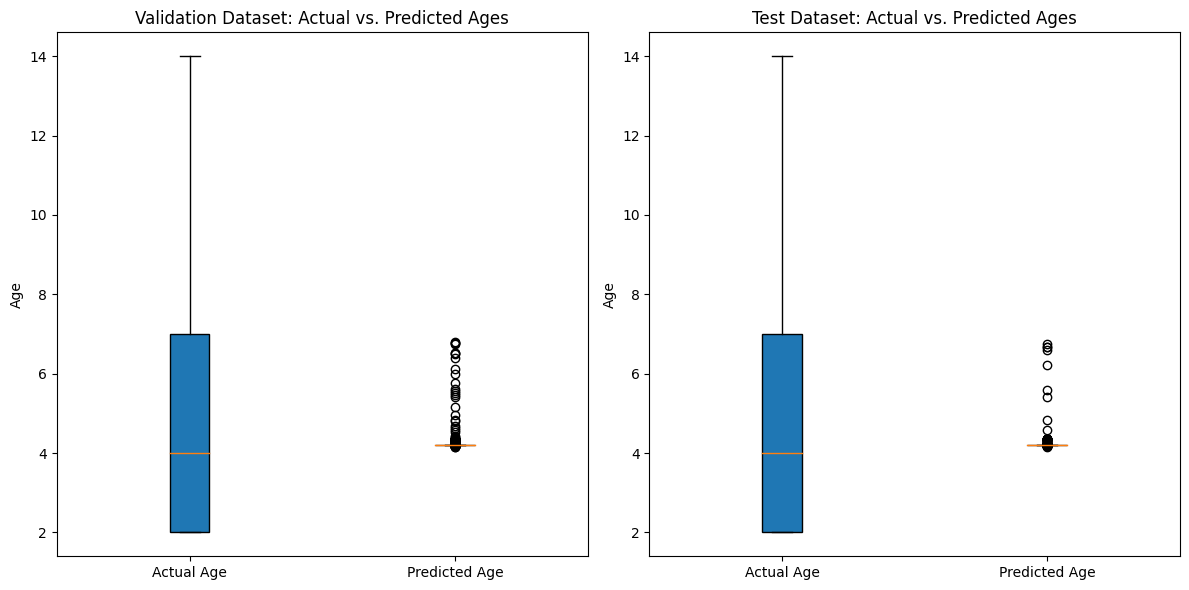

In [4]:
import matplotlib.pyplot as plt

# Validation dataset box plots
plt.figure(figsize=(12, 6))

# Creating box plots for actual and predicted ages on the validation dataset
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
data_to_plot_val = [y_val, y_val_pred]
plt.boxplot(data_to_plot_val, patch_artist=True, labels=['Actual Age', 'Predicted Age'])
plt.title('Validation Dataset: Actual vs. Predicted Ages')
plt.ylabel('Age')

# Test dataset box plots
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
data_to_plot_test = [y_test, y_test_pred]
plt.boxplot(data_to_plot_test, patch_artist=True, labels=['Actual Age', 'Predicted Age'])
plt.title('Test Dataset: Actual vs. Predicted Ages')
plt.ylabel('Age')

plt.tight_layout()
plt.show()


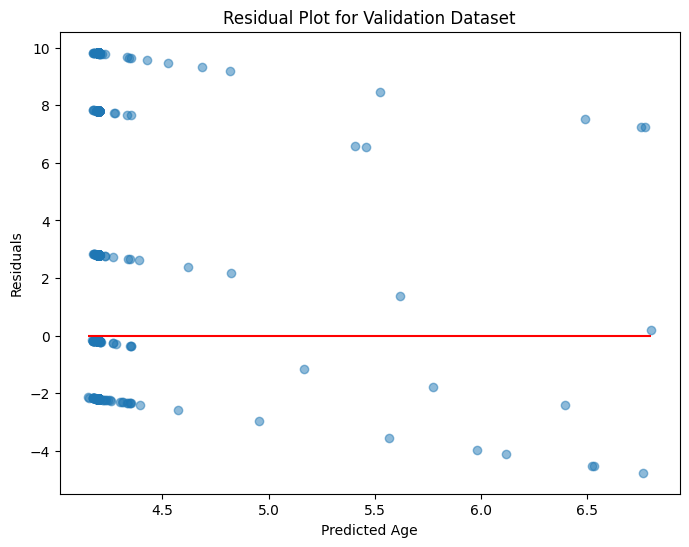

In [7]:
import matplotlib.pyplot as plt

# Calculate residuals for the validation set
residuals_val = y_val - y_val_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_val_pred, residuals_val, alpha=0.5)
plt.hlines(y=0, xmin=y_val_pred.min(), xmax=y_val_pred.max(), color='red')
plt.xlabel('Predicted Age')
plt.ylabel('Residuals')
plt.title('Residual Plot for Validation Dataset')
plt.show()


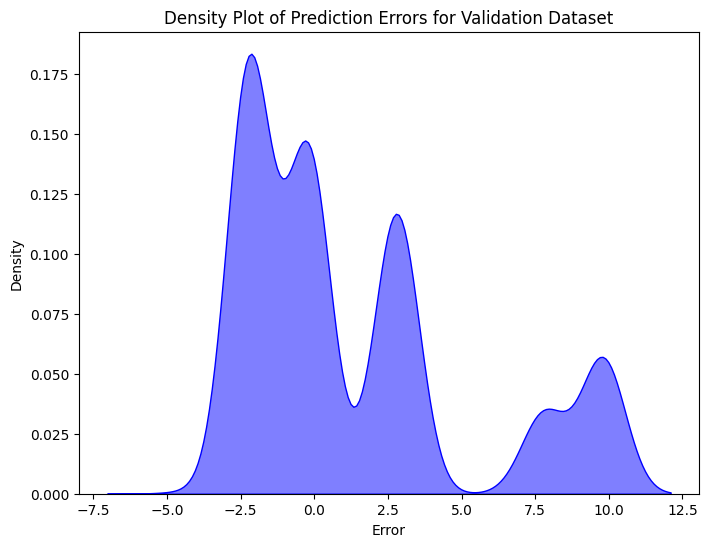

In [8]:
import seaborn as sns

# Calculate errors for the validation set
errors_val = y_val - y_val_pred

plt.figure(figsize=(8, 6))
sns.kdeplot(errors_val, fill=True, color="blue", alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Density Plot of Prediction Errors for Validation Dataset')
plt.show()
